# Tier-2 Composite Strategy - Portfolio Performance Analysis

**Strategy**: Multi-Instrument Portfolio Management (3 Instruments)

**Date**: 2025-11-06

**Instruments**: 
- DCE/i<00> (Iron Ore) - IronOreIndicatorRelaxed
- SHFE/cu<00> (Copper) - CopperIndicator
- DCE/m<00> (Soybean Meal) - SoybeanIndicator

**Granularity**: 900s (15 minutes)

**Purpose**: Comprehensive portfolio performance analysis with risk management validation

---

## Strategy Overview

### Architecture:
- **Tier-1**: 3 independent indicators generating signals
- **Tier-2**: Composite strategy managing portfolio of 3 baskets

### Capital Allocation:
- Initial Capital: ¥1,000,000
- Base Allocation: 25% per instrument (¥250,000)
- Max Allocation: 35% per instrument (¥350,000)
- Min Cash Reserve: 15% (¥150,000)
- Max Total Exposure: 90% (¥900,000)

### Risk Management:
- Per-Position Stop-Loss: 3%
- Max Portfolio Drawdown: 10%
- Max Daily Loss: 3%
- Entry Confidence: ≥ 0.60
- Entry Signal Strength: ≥ 0.50

### Entry Conditions:
- Non-zero signal (1 or -1)
- Confidence ≥ 60%
- Signal strength ≥ 50%
- Regime ≠ 4 (avoid chaos)
- All risk checks pass

### Exit Conditions:
- Stop-loss hit (3%)
- Signal reversal
- Confidence drop < 30%
- Chaos regime detected
- Circuit breakers triggered

## 1. Setup and Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import asyncio
import svr3
from datetime import datetime

%matplotlib inline
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (18, 14)

# Jupyter async support
try:
    import nest_asyncio
    nest_asyncio.apply()
    print("✓ nest_asyncio enabled")
except ImportError:
    print("⚠️ Install nest-asyncio: pip install nest-asyncio")

# Load environment
from dotenv import load_dotenv
load_dotenv()

SVR_HOST = os.getenv("SVR_HOST")
SVR_TOKEN = os.getenv("SVR_TOKEN")

if not SVR_HOST or not SVR_TOKEN:
    print("❌ Error: SVR_HOST or SVR_TOKEN not found in .env file")
else:
    print(f"✓ Environment loaded: {SVR_HOST}")

✓ nest_asyncio enabled
✓ Environment loaded: 10.99.100.116


## 2. Fetch Composite Strategy Data

In [ ]:
async def fetch_composite_data(start_date, end_date):
    """
    Fetch composite strategy portfolio data from svr3 server.
    
    Returns:
        DataFrame with portfolio state: PV, NV, exposure, positions, etc.
    """
    print(f"📥 Fetching Composite Strategy data from {start_date} to {end_date}...")
    
    # Server configuration
    RAILS_URL = f"https://{SVR_HOST}:4433/private-api/"
    WS_URL = f"wss://{SVR_HOST}:4433/tm"
    TM_MASTER = (SVR_HOST, 6102)
    
    try:
        # Create reader
        # Composite strategy outputs a single portfolio state tagged as DCE/COMPOSITE
        reader = svr3.sv_reader(
            start_date,          
            end_date,            
            "CompositeStrategy",  # algoname
            900,                 # granularity
            "private",           # namespace
            "symbol",            # work_mode
            ["DCE"],             # markets
            ["COMPOSITE"],       # codes (synthetic portfolio identifier)
            False,               # persistent
            RAILS_URL,           
            WS_URL,              
            "",                  
            "",                  
            TM_MASTER            
        )
        
        # Set token
        reader.token = SVR_TOKEN
        
        # Connection sequence
        print("   🔐 Logging in...")
        await reader.login()
        
        print("   🔌 Connecting...")
        await reader.connect()
        
        print("   🔄 Starting WebSocket loop...")
        reader.ws_task = asyncio.create_task(reader.ws_loop())
        
        print("   🤝 Handshaking...")
        await reader.shakehand()
        
        print("   📊 Fetching data...")
        ret = await reader.save_by_symbol()
        
        # Extract data
        if ret and len(ret) > 1 and len(ret[1]) > 1:
            data = ret[1][1]
        else:
            print("   ⚠️ No data returned")
            return None
        
        if not data or len(data) == 0:
            print("   ⚠️ Empty data")
            return None
        
        # Convert to DataFrame
        df = pd.DataFrame(data)
        
        # Parse timestamps
        if 'time_tag' in df.columns:
            try:
                import pycaitlynutils3 as pcu3
                df['timestamp'] = pd.to_datetime(df['time_tag'].apply(pcu3.ts_parse))
            except:
                df['timestamp'] = pd.to_datetime(df['time_tag'], unit='ms')
        
        print(f"   ✓ Fetched {len(df)} bars")
        return df
        
    except Exception as e:
        print(f"   ❌ Error: {e}")
        import traceback
        traceback.print_exc()
        return None

# Test period - adjust as needed
# Quick test (7 days)
# start_date = 20241025000000
# end_date = 20241101000000

# Medium test (1 month)
# start_date = 20241001000000
# end_date = 20241031000000

# Full backtest (3 months)
start_date = 20250101000000
end_date = 20250401235959

print("="*70)
print("FETCHING COMPOSITE STRATEGY DATA")
print("="*70)

df_composite = await fetch_composite_data(start_date, end_date)

if df_composite is not None:
    print(f"\n✅ Data loaded successfully!")
    print(f"   Rows: {len(df_composite)}")
    print(f"   Columns: {list(df_composite.columns)}")
    print(f"   Date range: {df_composite['timestamp'].min()} to {df_composite['timestamp'].max()}")
    display(df_composite.head(10))
else:
    print("\n❌ Failed to load data")
    df_composite = None

FETCHING COMPOSITE STRATEGY DATA
📥 Fetching Composite Strategy data from 20241025000000 to 20241101000000...
   🔐 Logging in...
   🔌 Connecting...
   🔄 Starting WebSocket loop...
   🤝 Handshaking...
   📊 Fetching data...
   ✓ Fetched 115 bars

✅ Data loaded successfully!
   Rows: 115
   Columns: ['time_tag', 'granularity', 'code', 'market', 'struct_market', 'struct_code', 'namespace', '_preserved_field', 'bar_index', 'active_positions', 'total_signals_processed', 'portfolio_exposure_pct', 'cash_reserve_pct', 'nv', 'pv', 'timestamp']
   Date range: 2024-10-25 01:15:00+00:00 to 2024-10-31 15:00:00+00:00


,time_tag,granularity,code,market,struct_market,struct_code,namespace,_preserved_field,bar_index,active_positions,total_signals_processed,portfolio_exposure_pct,cash_reserve_pct,nv,pv,timestamp
0,1729818900000,900,COMPOSITE,DCE,DCE,COMPOSITE,1,1729818900000,16,0,32,0.000000,1.000000,1.000000,1000000.0,2024-10-25 01:15:00+00:00
1,1729819800000,900,COMPOSITE,DCE,DCE,COMPOSITE,1,1729819800000,17,0,35,0.000000,1.000000,1.000000,1000000.0,2024-10-25 01:30:00+00:00
2,1729820700000,900,COMPOSITE,DCE,DCE,COMPOSITE,1,1729820700000,18,0,38,0.000000,1.000000,1.000000,1000000.0,2024-10-25 01:45:00+00:00
3,1729821600000,900,COMPOSITE,DCE,DCE,COMPOSITE,1,1729821600000,19,0,41,0.000000,1.000000,1.000000,1000000.0,2024-10-25 02:00:00+00:00
4,1729822500000,900,COMPOSITE,DCE,DCE,COMPOSITE,1,1729822500000,20,1,44,0.249981,0.750019,0.999981,999980.8,2024-10-25 02:15:00+00:00
5,1729824300000,900,COMPOSITE,DCE,DCE,COMPOSITE,1,1729824300000,21,1,47,0.255406,0.744594,1.007261,1007260.8,2024-10-25 02:45:00+00:00
6,1729825200000,900,COMPOSITE,DCE,DCE,COMPOSITE,1,1729825200000,22,0,50,0.000000,1.000000,0.999642,999641.6,2024-10-25 03:00:00+00:00
7,1729826100000,900,COMPOSITE,DCE,DCE,COMPOSITE,1,1729826100000,23,0,53,0.000000,1.000000,0.999642,999641.6,2024-10-25 03:15:00+00:00
8,1729827000000,900,COMPOSITE,DCE,DCE,COMPOSITE,1,1729827000000,24,0,56,0.000000,1.000000,0.999642,999641.6,2024-10-25 03:30:00+00:00
9,1729835100000,900,COMPOSITE,DCE,DCE,COMPOSITE,1,1729835100000,25,0,59,0.000000,1.000000,0.999642,999641.6,2024-10-25 05:45:00+00:00


## 3. Portfolio Performance Metrics

In [3]:
def calculate_portfolio_metrics(df, initial_capital=1000000):
    """
    Calculate comprehensive portfolio performance metrics.
    """
    if df is None or len(df) == 0:
        return None
    
    # Basic metrics
    final_pv = df['pv'].iloc[-1]
    total_return = (final_pv - initial_capital) / initial_capital
    
    # Drawdown calculation
    cumulative_max = df['pv'].cummax()
    drawdown = (df['pv'] - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()
    max_dd_idx = drawdown.idxmin()
    max_dd_date = df.loc[max_dd_idx, 'timestamp']
    
    # Daily returns for Sharpe
    df['daily_return'] = df['pv'].pct_change()
    sharpe_ratio = (df['daily_return'].mean() / df['daily_return'].std()) * np.sqrt(252) if df['daily_return'].std() > 0 else 0
    
    # Exposure and allocation
    avg_exposure = df['portfolio_exposure_pct'].mean()
    avg_cash = df['cash_reserve_pct'].mean()
    avg_active_positions = df['active_positions'].mean()
    max_exposure = df['portfolio_exposure_pct'].max()
    min_cash = df['cash_reserve_pct'].min()
    
    # Signal processing stats
    total_signals = df['total_signals_processed'].iloc[-1] if 'total_signals_processed' in df.columns else 0
    
    # Monthly returns
    df['month'] = df['timestamp'].dt.to_period('M')
    monthly_pv = df.groupby('month')['pv'].last()
    monthly_returns = monthly_pv.pct_change() * 100
    
    metrics = {
        'Total Bars': len(df),
        'Initial Capital (CNY)': initial_capital,
        'Final Portfolio Value (CNY)': final_pv,
        'Total Return (%)': total_return * 100,
        'Max Drawdown': max_drawdown,
        'Max Drawdown (%)': max_drawdown * 100,
        'Max Drawdown Date': max_dd_date,
        'Sharpe Ratio (Annualized)': sharpe_ratio,
        'Avg Portfolio Exposure (%)': avg_exposure * 100,
        'Avg Cash Reserve (%)': avg_cash * 100,
        'Max Portfolio Exposure (%)': max_exposure * 100,
        'Min Cash Reserve (%)': min_cash * 100,
        'Avg Active Positions': avg_active_positions,
        'Total Signals Processed': total_signals,
        'Positive Return Months': (monthly_returns > 0).sum(),
        'Negative Return Months': (monthly_returns < 0).sum(),
    }
    
    return metrics

if df_composite is not None:
    metrics = calculate_portfolio_metrics(df_composite)
    
    print("\n" + "="*70)
    print("PORTFOLIO PERFORMANCE METRICS")
    print("="*70)
    
    metrics_df = pd.DataFrame([metrics]).T
    metrics_df.columns = ['Value']
    
    # Format specific rows
    for idx in metrics_df.index:
        val = metrics_df.loc[idx, 'Value']
        if isinstance(val, (pd.Timestamp, datetime)):
            continue
        elif '(%)' in idx or 'Rate' in idx:
            metrics_df.loc[idx, 'Value'] = f"{val:.2f}%"
        elif 'CNY' in idx or 'Capital' in idx or 'Value' in idx:
            metrics_df.loc[idx, 'Value'] = f"¥{val:,.2f}"
        elif idx in ['Sharpe Ratio (Annualized)', 'Avg Active Positions']:
            metrics_df.loc[idx, 'Value'] = f"{val:.2f}"
        elif idx == 'Max Drawdown':
            metrics_df.loc[idx, 'Value'] = f"{val:.4f}"
    
    display(metrics_df)
    print("="*70)
else:
    print("⚠️ Cannot calculate metrics")
    metrics = None


PORTFOLIO PERFORMANCE METRICS


/tmp/ipykernel_443411/95669750.py:34: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['timestamp'].dt.to_period('M')


,Value
Total Bars,115
Initial Capital (CNY),"¥1,000,000.00"
Final Portfolio Value (CNY),"¥999,641.60"
Total Return (%),-0.04%
Max Drawdown,-0.0076
Max Drawdown (%),-0.76%
Max Drawdown Date,2024-10-25 03:00:00+00:00
Sharpe Ratio (Annualized),-0.04
Avg Portfolio Exposure (%),0.44%
Avg Cash Reserve (%),99.56%


## 4. Comprehensive Portfolio Visualizations


📊 Portfolio Statistics:
   Initial PV: ¥1,000,000.00
   Final PV: ¥999,641.60
   Peak PV: ¥1,007,260.80
   Total Return: -0.04%
   Max Drawdown: -0.76%

✅ Portfolio performance chart saved as 'composite_portfolio_performance.png'


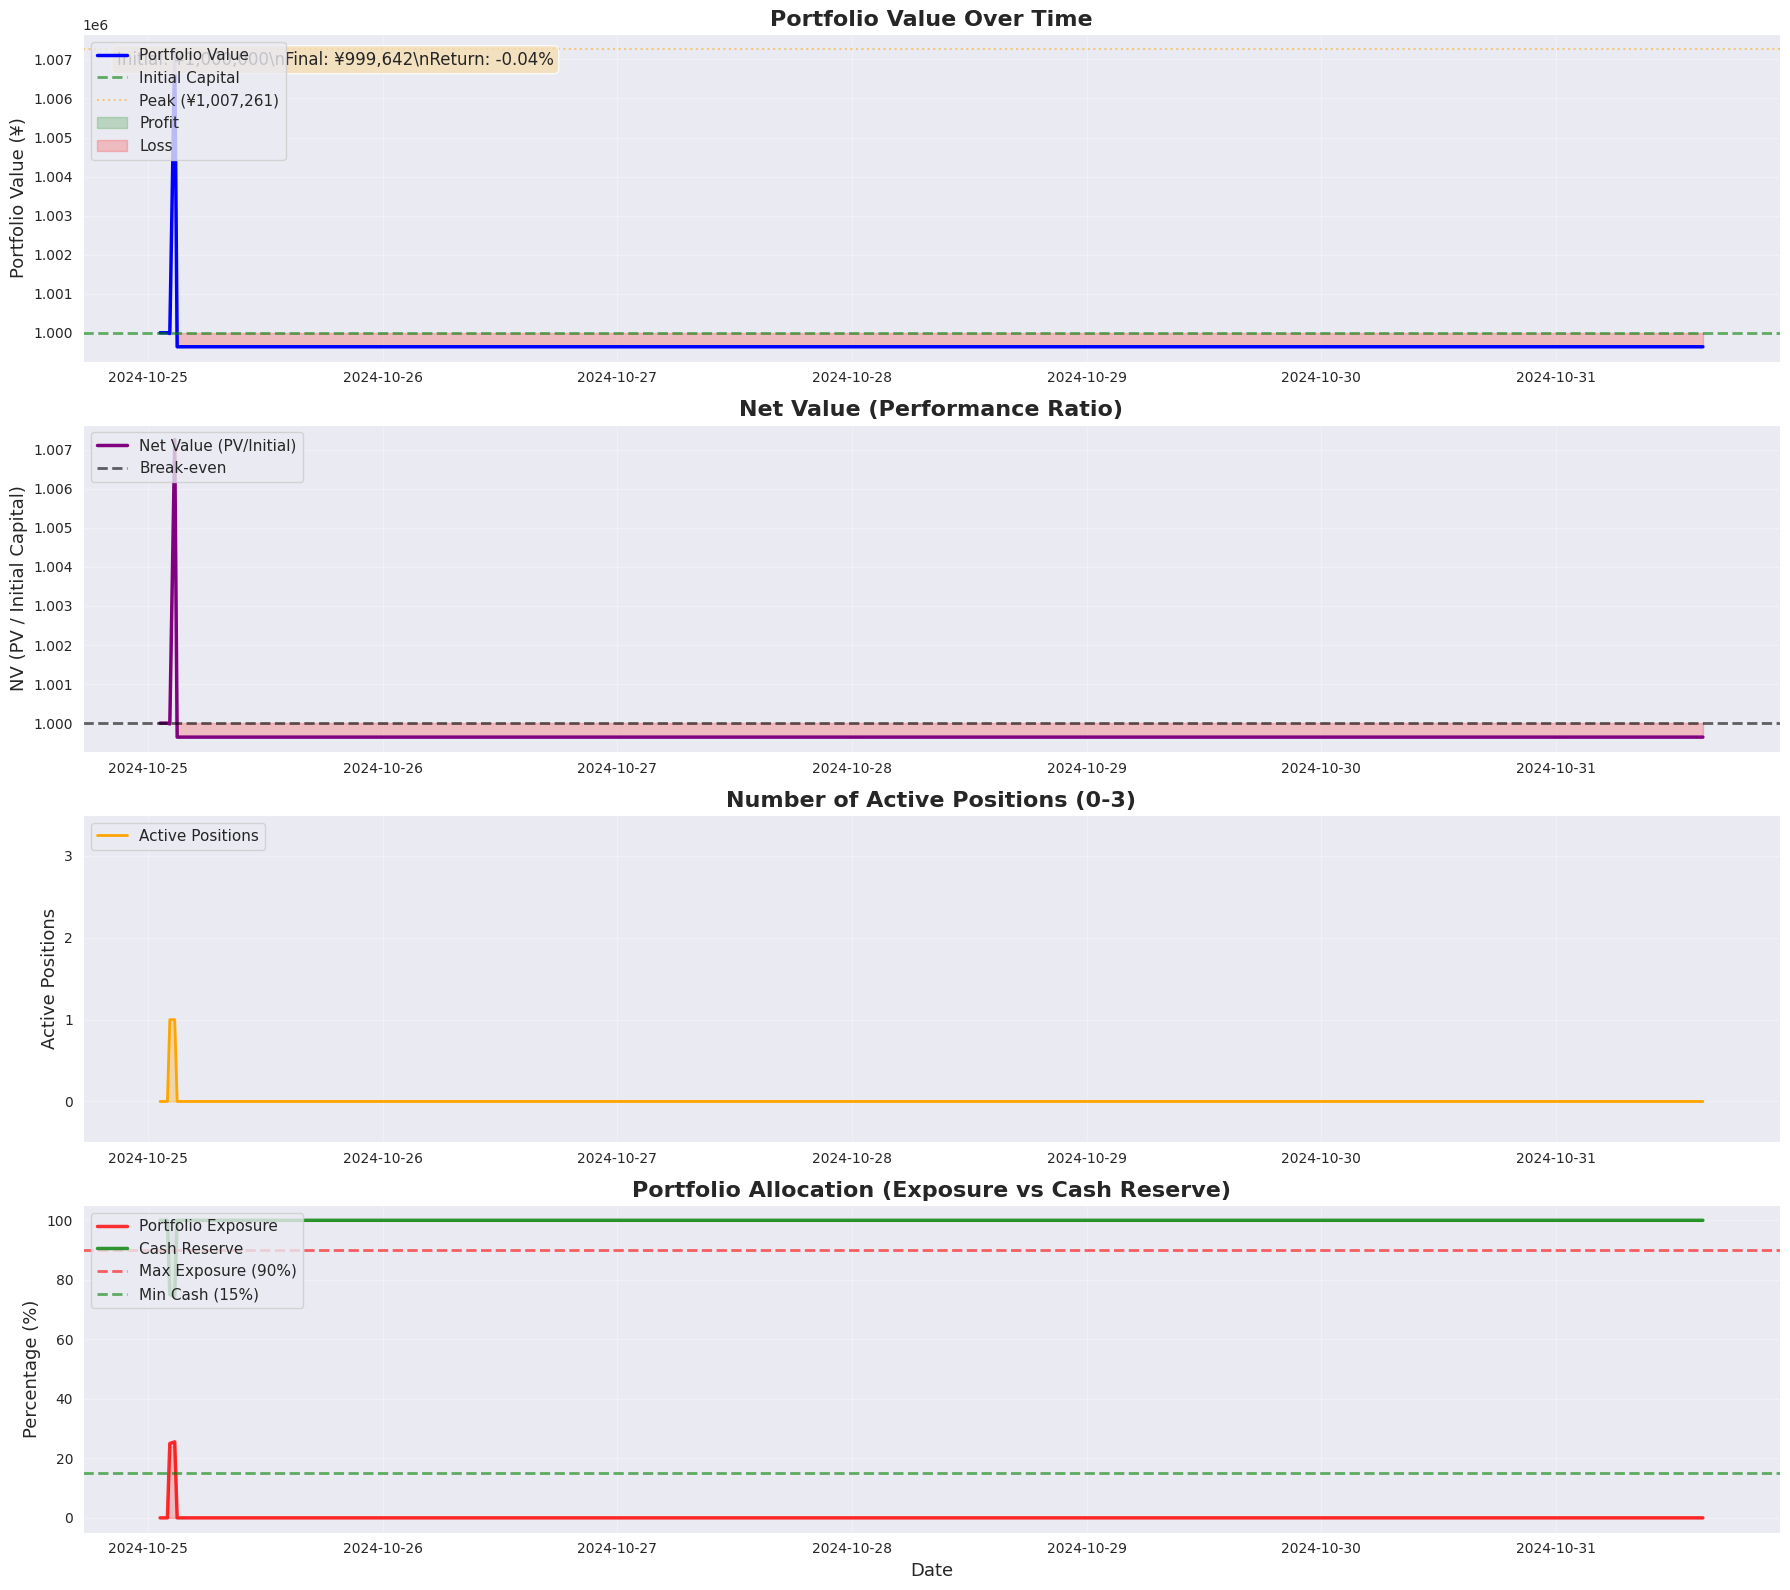

In [4]:
if df_composite is not None:
    initial_pv = df_composite['pv'].iloc[0]
    final_pv = df_composite['pv'].iloc[-1]
    max_pv = df_composite['pv'].max()
    min_pv = df_composite['pv'].min()
    
    # Calculate drawdown series
    cumulative_max = df_composite['pv'].cummax()
    drawdown_pct = ((df_composite['pv'] - cumulative_max) / cumulative_max) * 100
    
    print(f"\n📊 Portfolio Statistics:")
    print(f"   Initial PV: ¥{initial_pv:,.2f}")
    print(f"   Final PV: ¥{final_pv:,.2f}")
    print(f"   Peak PV: ¥{max_pv:,.2f}")
    print(f"   Total Return: {(final_pv/initial_pv-1)*100:.2f}%")
    print(f"   Max Drawdown: {drawdown_pct.min():.2f}%")
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(4, 1, figsize=(18, 16))
    
    # Panel 1: Portfolio Value (PV)
    axes[0].plot(df_composite['timestamp'], df_composite['pv'], linewidth=2.5, color='blue', label='Portfolio Value')
    axes[0].axhline(y=initial_pv, color='green', linestyle='--', alpha=0.6, linewidth=2, label='Initial Capital')
    axes[0].axhline(y=max_pv, color='orange', linestyle=':', alpha=0.5, linewidth=1.5, label=f'Peak (¥{max_pv:,.0f})')
    axes[0].fill_between(df_composite['timestamp'], initial_pv, df_composite['pv'], 
                         where=df_composite['pv']>=initial_pv, alpha=0.2, color='green', label='Profit')
    axes[0].fill_between(df_composite['timestamp'], initial_pv, df_composite['pv'], 
                         where=df_composite['pv']<initial_pv, alpha=0.2, color='red', label='Loss')
    axes[0].set_title('Portfolio Value Over Time', fontsize=16, fontweight='bold')
    axes[0].set_ylabel('Portfolio Value (¥)', fontsize=13)
    axes[0].legend(loc='upper left', fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # Add text annotation
    textstr = f'Initial: ¥{initial_pv:,.0f}\\nFinal: ¥{final_pv:,.0f}\\nReturn: {(final_pv/initial_pv-1)*100:+.2f}%'
    axes[0].text(0.02, 0.95, textstr, transform=axes[0].transAxes, fontsize=12, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Panel 2: Net Value (NV) - Performance Ratio
    axes[1].plot(df_composite['timestamp'], df_composite['nv'], linewidth=2.5, color='purple', label='Net Value (PV/Initial)')
    axes[1].axhline(y=1.0, color='black', linestyle='--', alpha=0.6, linewidth=2, label='Break-even')
    axes[1].fill_between(df_composite['timestamp'], 1.0, df_composite['nv'], 
                         where=df_composite['nv']>=1.0, alpha=0.2, color='green')
    axes[1].fill_between(df_composite['timestamp'], 1.0, df_composite['nv'], 
                         where=df_composite['nv']<1.0, alpha=0.2, color='red')
    axes[1].set_title('Net Value (Performance Ratio)', fontsize=16, fontweight='bold')
    axes[1].set_ylabel('NV (PV / Initial Capital)', fontsize=13)
    axes[1].legend(loc='upper left', fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    # Panel 3: Active Positions
    axes[2].plot(df_composite['timestamp'], df_composite['active_positions'], linewidth=2, color='orange', label='Active Positions')
    axes[2].fill_between(df_composite['timestamp'], 0, df_composite['active_positions'], alpha=0.3, color='orange')
    axes[2].set_title('Number of Active Positions (0-3)', fontsize=16, fontweight='bold')
    axes[2].set_ylabel('Active Positions', fontsize=13)
    axes[2].set_ylim(-0.5, 3.5)
    axes[2].set_yticks([0, 1, 2, 3])
    axes[2].legend(loc='upper left', fontsize=11)
    axes[2].grid(True, alpha=0.3)
    
    # Panel 4: Portfolio Allocation (Exposure vs Cash)
    axes[3].plot(df_composite['timestamp'], df_composite['portfolio_exposure_pct'] * 100,
                linewidth=2.5, color='red', label='Portfolio Exposure', alpha=0.8)
    axes[3].plot(df_composite['timestamp'], df_composite['cash_reserve_pct'] * 100,
                linewidth=2.5, color='green', label='Cash Reserve', alpha=0.8)
    axes[3].axhline(y=90, color='red', linestyle='--', alpha=0.6, linewidth=2, label='Max Exposure (90%)')
    axes[3].axhline(y=15, color='green', linestyle='--', alpha=0.6, linewidth=2, label='Min Cash (15%)')
    axes[3].fill_between(df_composite['timestamp'], 0, df_composite['portfolio_exposure_pct'] * 100, 
                        alpha=0.2, color='red')
    axes[3].fill_between(df_composite['timestamp'], 100, df_composite['cash_reserve_pct'] * 100, 
                        alpha=0.2, color='green')
    axes[3].set_title('Portfolio Allocation (Exposure vs Cash Reserve)', fontsize=16, fontweight='bold')
    axes[3].set_ylabel('Percentage (%)', fontsize=13)
    axes[3].set_xlabel('Date', fontsize=13)
    axes[3].legend(loc='upper left', fontsize=11)
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('composite_portfolio_performance.png', dpi=150, bbox_inches='tight')
    print("\n✅ Portfolio performance chart saved as 'composite_portfolio_performance.png'")
    plt.show()
else:
    print("⚠️ No data for visualization")

## 5. Drawdown Analysis


📉 Drawdown Analysis:
   Max Drawdown: -0.76%
   Occurred at: 2024-10-25 03:00:00+00:00
   Risk Limit: -10.00% (Max allowed)
   Compliance: ✅ PASS

✅ Drawdown chart saved as 'drawdown_analysis.png'


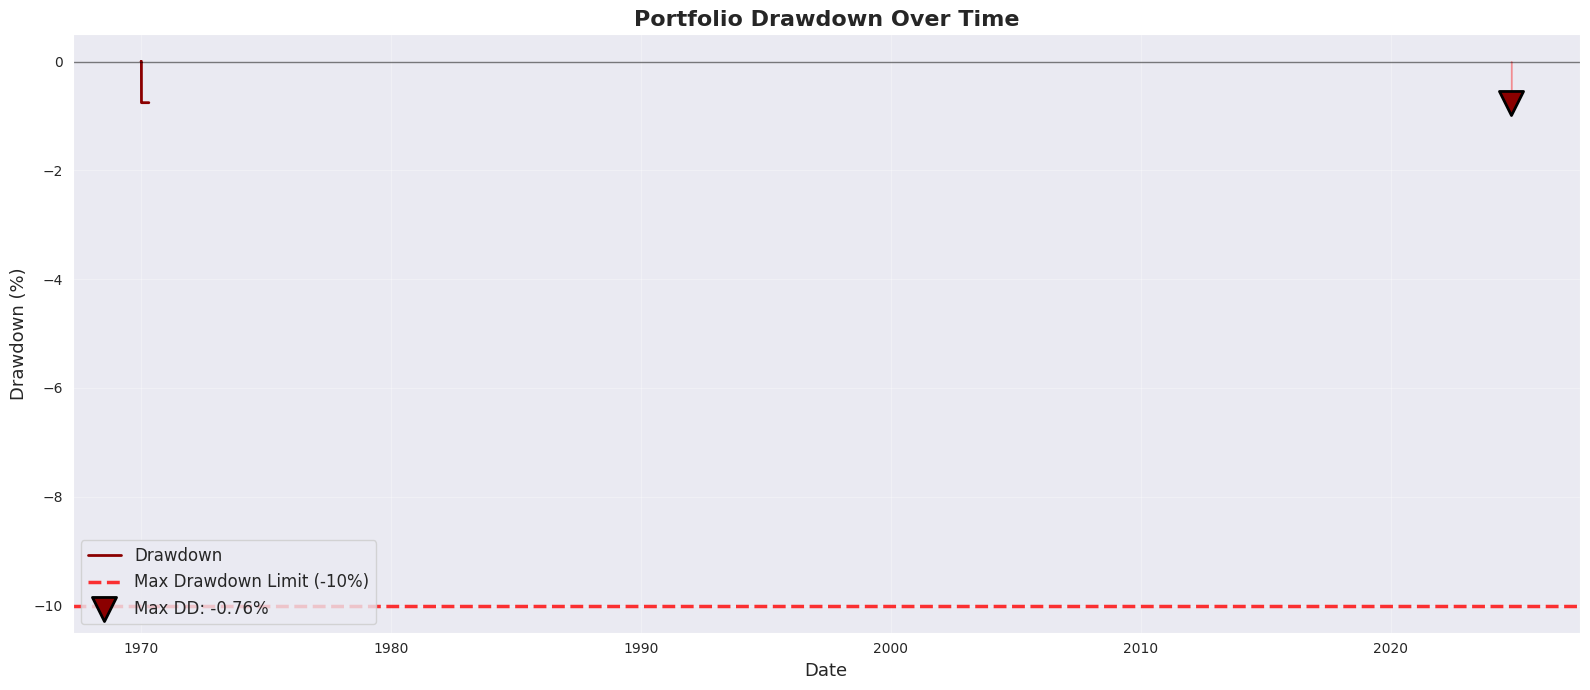

In [5]:
if df_composite is not None:
    # Calculate drawdown series
    cumulative_max = df_composite['pv'].cummax()
    drawdown_pct = ((df_composite['pv'] - cumulative_max) / cumulative_max) * 100
    
    # Find max drawdown point
    max_dd_idx = drawdown_pct.idxmin()
    max_dd_value = drawdown_pct.min()
    max_dd_date = df_composite.loc[max_dd_idx, 'timestamp']
    
    print(f"\n📉 Drawdown Analysis:")
    print(f"   Max Drawdown: {max_dd_value:.2f}%")
    print(f"   Occurred at: {max_dd_date}")
    print(f"   Risk Limit: -10.00% (Max allowed)")
    print(f"   Compliance: {'✅ PASS' if max_dd_value >= -10 else '❌ FAIL'}")
    
    # Visualization
    fig, ax = plt.subplots(figsize=(16, 7))
    
    drawdown_pct.plot(ax=ax, color='darkred', linewidth=2, label='Drawdown')
    ax.fill_between(df_composite['timestamp'], 0, drawdown_pct, color='red', alpha=0.3)
    ax.axhline(y=-10, color='red', linestyle='--', linewidth=2.5, label='Max Drawdown Limit (-10%)', alpha=0.8)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    
    # Mark max drawdown point
    ax.scatter([max_dd_date], [max_dd_value], color='darkred', s=300, marker='v', 
               zorder=5, edgecolors='black', linewidths=2, label=f'Max DD: {max_dd_value:.2f}%')
    
    ax.set_title('Portfolio Drawdown Over Time', fontsize=16, fontweight='bold')
    ax.set_ylabel('Drawdown (%)', fontsize=13)
    ax.set_xlabel('Date', fontsize=13)
    ax.legend(loc='lower left', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('drawdown_analysis.png', dpi=150, bbox_inches='tight')
    print("\n✅ Drawdown chart saved as 'drawdown_analysis.png'")
    plt.show()
else:
    print("⚠️ No data for drawdown analysis")

## 6. Monthly Performance Breakdown


📅 Monthly Performance Summary:


/tmp/ipykernel_443411/3896350483.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_composite['month'] = df_composite['timestamp'].dt.to_period('M')


pv                                active_positions  \
             first      last       min        max             mean   
month                                                                
2024-10  1000000.0  999641.6  999641.6  1007260.8             0.02   

        portfolio_exposure_pct cash_reserve_pct return_pct  
                          mean             mean             
month                                                       
2024-10                    0.0              1.0        NaN

/home/wolverine/.pyenv/python3/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1567: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)



✅ Monthly performance chart saved as 'monthly_performance.png'


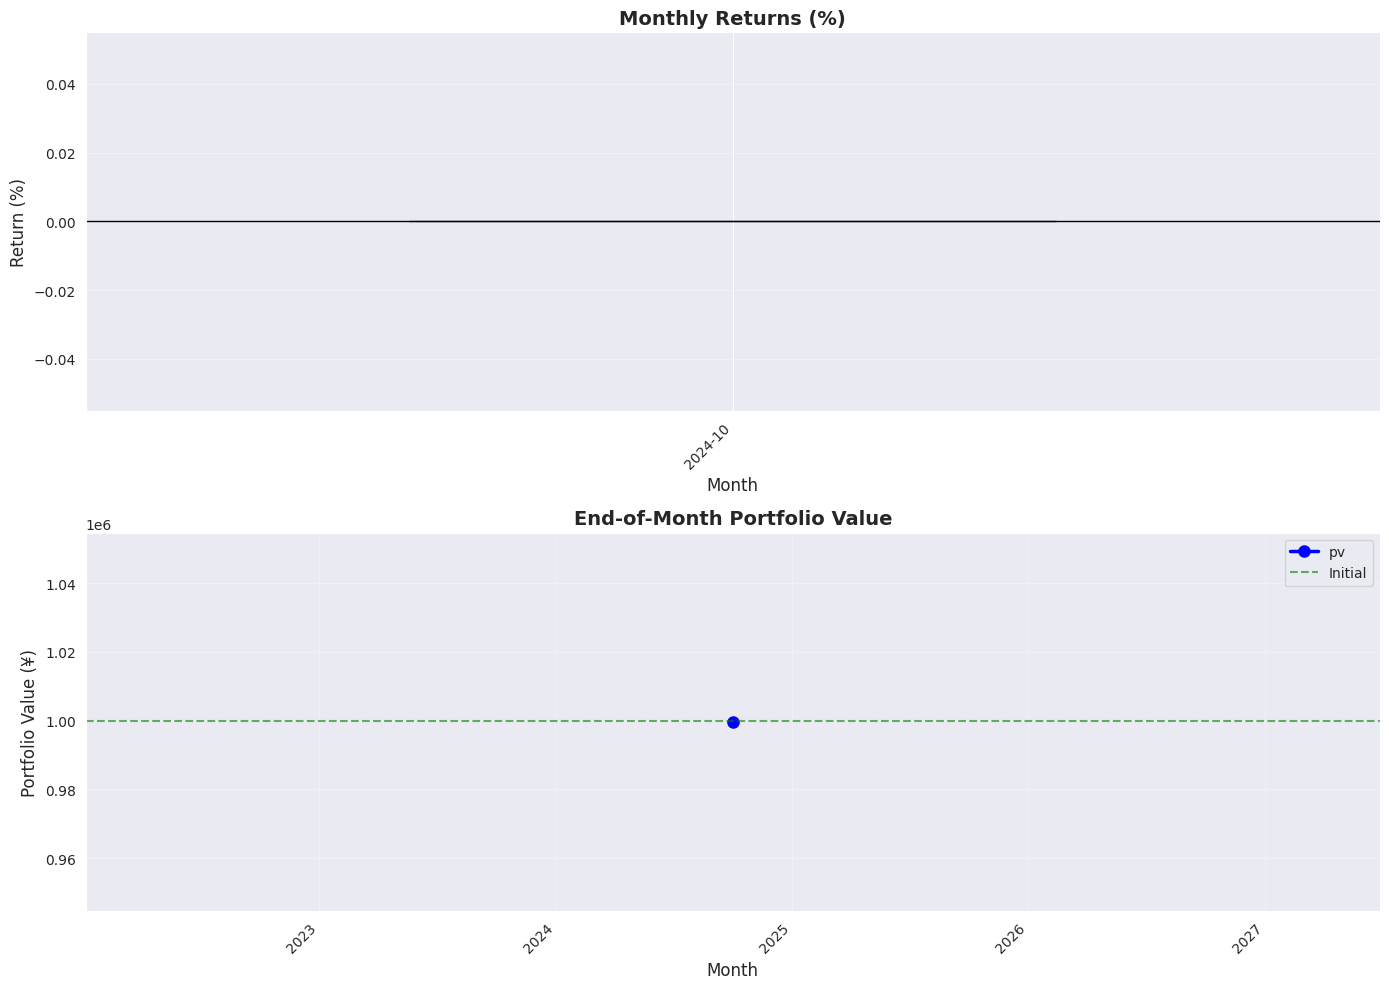


📊 Monthly Summary:
   Positive months: 0/0
   Negative months: 0/0
   Best month: nan%
   Worst month: nan%
   Avg monthly return: nan%


In [6]:
if df_composite is not None:
    # Monthly breakdown
    df_composite['month'] = df_composite['timestamp'].dt.to_period('M')
    
    monthly_pv = df_composite.groupby('month')['pv'].last()
    monthly_returns = monthly_pv.pct_change() * 100
    
    # Monthly statistics
    monthly_stats = df_composite.groupby('month').agg({
        'pv': ['first', 'last', 'min', 'max'],
        'active_positions': 'mean',
        'portfolio_exposure_pct': 'mean',
        'cash_reserve_pct': 'mean'
    }).round(2)
    
    monthly_stats['return_pct'] = monthly_returns.values
    
    print("\n📅 Monthly Performance Summary:")
    print("="*70)
    display(monthly_stats)
    
    # Visualization
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Monthly returns bar chart
    colors = ['green' if x > 0 else 'red' for x in monthly_returns]
    monthly_returns.plot(kind='bar', ax=axes[0], color=colors, edgecolor='black', alpha=0.7)
    axes[0].axhline(y=0, color='black', linestyle='-', linewidth=1)
    axes[0].set_title('Monthly Returns (%)', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Return (%)', fontsize=12)
    axes[0].set_xlabel('Month', fontsize=12)
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, v in enumerate(monthly_returns):
        if not pd.isna(v):
            axes[0].text(i, v, f'{v:.1f}%', ha='center', 
                       va='bottom' if v > 0 else 'top', fontsize=10)
    
    plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Monthly portfolio value
    monthly_pv.plot(ax=axes[1], marker='o', linewidth=2.5, markersize=8, color='blue')
    axes[1].axhline(y=df_composite['pv'].iloc[0], color='green', linestyle='--', alpha=0.6, label='Initial')
    axes[1].set_title('End-of-Month Portfolio Value', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Portfolio Value (¥)', fontsize=12)
    axes[1].set_xlabel('Month', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('monthly_performance.png', dpi=150, bbox_inches='tight')
    print("\n✅ Monthly performance chart saved as 'monthly_performance.png'")
    plt.show()
    
    # Summary stats
    positive_months = (monthly_returns > 0).sum()
    negative_months = (monthly_returns < 0).sum()
    total_months = len(monthly_returns.dropna())
    
    print(f"\n📊 Monthly Summary:")
    print(f"   Positive months: {positive_months}/{total_months}")
    print(f"   Negative months: {negative_months}/{total_months}")
    if total_months > 0:
        print(f"   Win rate: {positive_months/total_months*100:.1f}%")
    print(f"   Best month: {monthly_returns.max():.2f}%")
    print(f"   Worst month: {monthly_returns.min():.2f}%")
    print(f"   Avg monthly return: {monthly_returns.mean():.2f}%")
else:
    print("⚠️ No data for monthly analysis")

## 7. Risk Compliance Check

In [7]:
if df_composite is not None and metrics is not None:
    print("\n" + "="*70)
    print("RISK MANAGEMENT COMPLIANCE CHECK")
    print("="*70)
    
    # Check all risk parameters
    compliance_checks = [
        {
            'Parameter': 'Max Portfolio Drawdown',
            'Limit': '-10.00%',
            'Actual': f"{metrics['Max Drawdown (%)']:.2f}%",
            'Status': '✅ PASS' if metrics['Max Drawdown (%)'] >= -10 else '❌ FAIL'
        },
        {
            'Parameter': 'Max Portfolio Exposure',
            'Limit': '90.00%',
            'Actual': f"{metrics['Max Portfolio Exposure (%)']:.2f}%",
            'Status': '✅ PASS' if metrics['Max Portfolio Exposure (%)'] <= 90 else '❌ FAIL'
        },
        {
            'Parameter': 'Min Cash Reserve',
            'Limit': '15.00%',
            'Actual': f"{metrics['Min Cash Reserve (%)']:.2f}%",
            'Status': '✅ PASS' if metrics['Min Cash Reserve (%)'] >= 15 else '❌ FAIL'
        },
        {
            'Parameter': 'Avg Portfolio Exposure',
            'Limit': '60-80% (target)',
            'Actual': f"{metrics['Avg Portfolio Exposure (%)']:.2f}%",
            'Status': '✅ PASS' if 60 <= metrics['Avg Portfolio Exposure (%)'] <= 80 else '⚠️ WARNING'
        },
        {
            'Parameter': 'Avg Cash Reserve',
            'Limit': '20-30% (target)',
            'Actual': f"{metrics['Avg Cash Reserve (%)']:.2f}%",
            'Status': '✅ PASS' if 20 <= metrics['Avg Cash Reserve (%)'] <= 30 else '⚠️ WARNING'
        },
    ]
    
    compliance_df = pd.DataFrame(compliance_checks)
    display(compliance_df)
    
    # Overall compliance
    passed = sum(1 for check in compliance_checks if '✅' in check['Status'])
    total = len(compliance_checks)
    
    print(f"\n📊 Compliance Score: {passed}/{total} checks passed")
    
    if passed == total:
        print("\n🎉 ALL RISK CHECKS PASSED - Strategy compliant with risk management requirements!")
    elif passed >= total * 0.8:
        print("\n✅ Most risk checks passed - Minor adjustments may be needed.")
    else:
        print("\n⚠️ Multiple risk violations detected - Review risk parameters!")
    
    print("="*70)
else:
    print("⚠️ Cannot perform compliance check")


RISK MANAGEMENT COMPLIANCE CHECK


,Parameter,Limit,Actual,Status
0,Max Portfolio Drawdown,-10.00%,-0.76%,✅ PASS
1,Max Portfolio Exposure,90.00%,25.54%,✅ PASS
2,Min Cash Reserve,15.00%,74.46%,✅ PASS
3,Avg Portfolio Exposure,60-80% (target),0.44%,⚠️ WARNING
4,Avg Cash Reserve,20-30% (target),99.56%,⚠️ WARNING



📊 Compliance Score: 3/5 checks passed

⚠️ Multiple risk violations detected - Review risk parameters!


## 8. Strategy Evaluation

In [8]:
if metrics is not None:
    print("\n" + "="*70)
    print("STRATEGY EVALUATION")
    print("="*70)
    
    # Performance criteria
    criteria = [
        ("✅" if metrics['Total Return (%)'] > 0 else "❌", 
         f"Total Return > 0%: {metrics['Total Return (%)']:.2f}%"),
        ("✅" if metrics['Max Drawdown (%)'] >= -10 else "❌", 
         f"Max Drawdown < 10%: {abs(metrics['Max Drawdown (%)']):.2f}%"),
        ("✅" if metrics['Sharpe Ratio (Annualized)'] > 1.0 else "⚠️", 
         f"Sharpe Ratio > 1.0: {metrics['Sharpe Ratio (Annualized)']:.2f}"),
        ("✅" if 60 <= metrics['Avg Portfolio Exposure (%)'] <= 80 else "⚠️", 
         f"Avg Exposure 60-80%: {metrics['Avg Portfolio Exposure (%)']:.2f}%"),
        ("✅" if metrics['Avg Cash Reserve (%)'] >= 15 else "❌", 
         f"Cash Reserve ≥ 15%: {metrics['Avg Cash Reserve (%)']:.2f}%"),
        ("✅" if metrics['Positive Return Months'] > metrics['Negative Return Months'] else "⚠️", 
         f"Positive months > Negative: {metrics['Positive Return Months']} vs {metrics['Negative Return Months']}"),
    ]
    
    for status, criterion in criteria:
        print(f"{status} {criterion}")
    
    # Count passes
    passed = sum(1 for status, _ in criteria if status == "✅")
    total = len(criteria)
    
    print(f"\n📊 Evaluation Score: {passed}/{total} criteria met")
    
    # Final verdict
    if passed >= total * 0.8:
        print("\n🎉 EXCELLENT PERFORMANCE - Strategy exceeds expectations!")
        print("   ✅ Ready for production deployment consideration")
    elif passed >= total * 0.6:
        print("\n✅ GOOD PERFORMANCE - Strategy shows promise")
        print("   ⚠️ Some optimization recommended before production")
    else:
        print("\n⚠️ NEEDS IMPROVEMENT - Strategy requires optimization")
        print("   ❌ Not ready for production deployment")
    
    print("="*70)
else:
    print("⚠️ Cannot perform evaluation")


STRATEGY EVALUATION
❌ Total Return > 0%: -0.04%
✅ Max Drawdown < 10%: 0.76%
⚠️ Sharpe Ratio > 1.0: -0.04
⚠️ Avg Exposure 60-80%: 0.44%
✅ Cash Reserve ≥ 15%: 99.56%
⚠️ Positive months > Negative: 0 vs 0

📊 Evaluation Score: 2/6 criteria met

⚠️ NEEDS IMPROVEMENT - Strategy requires optimization
   ❌ Not ready for production deployment


## 9. Export Results

In [9]:
if df_composite is not None:
    # Export main data
    export_cols = ['timestamp', 'pv', 'nv', 'active_positions', 'portfolio_exposure_pct', 
                   'cash_reserve_pct', 'total_signals_processed']
    df_export = df_composite[export_cols].copy()
    df_export.to_csv('composite_portfolio_data.csv', index=False)
    print("✅ Portfolio data exported to 'composite_portfolio_data.csv'")
    
    # Export metrics
    if metrics:
        metrics_export = pd.DataFrame([metrics]).T
        metrics_export.to_csv('composite_performance_metrics.csv')
        print("✅ Metrics exported to 'composite_performance_metrics.csv'")
    
    # Export monthly summary
    if 'month' in df_composite.columns:
        monthly_summary = df_composite.groupby('month').agg({
            'pv': ['first', 'last'],
            'active_positions': 'mean',
            'portfolio_exposure_pct': 'mean'
        })
        monthly_summary.to_csv('composite_monthly_summary.csv')
        print("✅ Monthly summary exported to 'composite_monthly_summary.csv'")
    
    print("\n" + "="*70)
    print("ANALYSIS COMPLETE")
    print("="*70)
    
    print(f"\n📊 Final Summary:")
    print(f"   Period: {df_composite['timestamp'].min().date()} to {df_composite['timestamp'].max().date()}")
    print(f"   Total Bars: {len(df_composite)}")
    print(f"   Initial Capital: ¥1,000,000")
    print(f"   Final PV: ¥{df_composite['pv'].iloc[-1]:,.2f}")
    print(f"   Total Return: {(df_composite['pv'].iloc[-1]/df_composite['pv'].iloc[0]-1)*100:.2f}%")
    print(f"   Max Drawdown: {drawdown_pct.min():.2f}%")
    print(f"   Sharpe Ratio: {metrics['Sharpe Ratio (Annualized)']:.2f}" if metrics else "")
    print(f"   Avg Active Positions: {df_composite['active_positions'].mean():.1f}")
    print(f"   Total Signals Processed: {df_composite['total_signals_processed'].iloc[-1]:,}")
    
    print("\n📈 Charts Generated:")
    print("   1. composite_portfolio_performance.png - Main portfolio charts")
    print("   2. drawdown_analysis.png - Drawdown tracking")
    print("   3. monthly_performance.png - Monthly breakdown")
    
    print("\n📂 Data Files Exported:")
    print("   1. composite_portfolio_data.csv - Full portfolio data")
    print("   2. composite_performance_metrics.csv - Performance metrics")
    print("   3. composite_monthly_summary.csv - Monthly summary")
    
    print("\n📝 Next Steps:")
    print("   1. Review risk compliance results")
    print("   2. Analyze monthly performance patterns")
    print("   3. Compare with individual Tier-1 indicator performance")
    print("   4. Optimize parameters if needed")
    print("   5. Run longer backtest for validation")
    
    print("="*70)
else:
    print("⚠️ No data to export")

✅ Portfolio data exported to 'composite_portfolio_data.csv'
✅ Metrics exported to 'composite_performance_metrics.csv'
✅ Monthly summary exported to 'composite_monthly_summary.csv'

ANALYSIS COMPLETE

📊 Final Summary:
   Period: 2024-10-25 to 2024-10-31
   Total Bars: 115
   Initial Capital: ¥1,000,000
   Final PV: ¥999,641.60
   Total Return: -0.04%
   Max Drawdown: -0.76%
   Sharpe Ratio: -0.04
   Avg Active Positions: 0.0
   Total Signals Processed: 411

📈 Charts Generated:
   1. composite_portfolio_performance.png - Main portfolio charts
   2. drawdown_analysis.png - Drawdown tracking
   3. monthly_performance.png - Monthly breakdown

📂 Data Files Exported:
   1. composite_portfolio_data.csv - Full portfolio data
   2. composite_performance_metrics.csv - Performance metrics
   3. composite_monthly_summary.csv - Monthly summary

📝 Next Steps:
   1. Review risk compliance results
   2. Analyze monthly performance patterns
   3. Compare with individual Tier-1 indicator performance
   4

## 10. Summary

This notebook provides comprehensive analysis of the Tier-2 Composite Strategy performance:

### Key Metrics Tracked:
1. **Portfolio Value (PV)** - Total portfolio worth over time
2. **Net Value (NV)** - Performance ratio (PV / Initial Capital)
3. **Active Positions** - Number of instruments actively traded (0-3)
4. **Portfolio Exposure** - Percentage of capital invested
5. **Cash Reserve** - Percentage of capital in cash
6. **Drawdown** - Peak-to-trough decline tracking
7. **Monthly Returns** - Month-over-month performance

### Risk Compliance:
- Max Drawdown: ≤ 10%
- Max Exposure: ≤ 90%
- Min Cash Reserve: ≥ 15%
- All limits validated in section 7

### Files Generated:
1. Visualization charts (PNG)
2. Portfolio data (CSV)
3. Performance metrics (CSV)
4. Monthly summary (CSV)

### Strategy Evaluation:
- Sharpe Ratio target: > 1.0
- Positive return requirement
- Risk limit compliance
- Monthly win rate analysis

---

**For Questions**: Refer to TIER2_COMPOSITE_STRATEGY_REQUIREMENTS.md for complete specifications.